In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import norm 
import time 

## Table des matières.

1. [Le Delta $\left(\Delta\right)$](#part1)  
   1.1 [Calcul pour un call / put](#part11)  
   1.2 [Implémentation](#part12)  
   1.3 [Approximations par différences finies](#part13)  
   1.4 [$\Delta$-hedging](#part14)  

2. [Le Gamma $\left(\Gamma\right)$](#part2)  
   2.1 [Calcul pour un call / put](#part21)  
   2.2 [Implémentation](#part22)  
   2.3 [Maximalité pour les options ATM](#part23)  
   2.4 [Approximations par différences finies](#part24)  
   2.5 [$\Gamma$-hedging](#part25)  

3. [Le Thêta $\left(\Theta\right)$](#part3)  
   3.1 [Calcul pour un call / put](#part31)  
   3.2 [Implémentation](#part32)  
   3.3 [Approximations par différences finies](#part33)  

4. [Le Rhô $\left(\rho\right)$](#part4)  
   4.1 [Calcul pour un call / put](#part41)  
   4.2 [Implémentation](#part42)  
   4.3 [Approximations par différences finies](#part43)  

5. [Le Vega $\left(\text{Vega}\right)$](#part5)  
   5.1 [Calcul pour un call / put](#part51)  
   5.2 [Implémentation et croissance en fonction de la maturité](#part52)  
   5.3 [Approximations par différences finies](#part53)  
   5.4 [Le Vanna $\left(\text{Vanna}\right)$](#part54)  
   5.5 [Le Volga $\left(\text{Volga}\right)$](#part55)  

6. [EDP de Black-Scholes](#part6)  \
    6.1 [Preuve](#part62)\
    6.2 [Interprétation financière et lien avec les grecques](#part62)

[Appendice : Preuve de la formule ($\star$)](#partappendice)


Ce document est consacré à l'étude des *Greeks*, qui sont des indicateurs cruciaux afin d'évaluer les options (notamment dans le modèle de Black-Scholes), mais également pour pouvoir créer des stratégies de couverture (*$\Delta$-hedging*)...

$$\tilde{}$$

Soit $V$ la valeur du portefeuille portant sur **un seul** actif sous jacent, dont le spot sera noté $S$. 
Nous adopterons les notations suivantes : 
* $K$, le strike de l'option. 
* $\sigma$, la volatilité.
* $T$, la maturité de l'option. 
* $r$, le taux d'intérêt. 
* $q$, le taux de dividende de l'actif sous-jacent, versé à rythme continu. 

$$ \tilde{} $$

Nous rappellons les formules de Black-Scholes pour un call et un put européen (pour plus de détails à ce sujet, je vous invite à consulter *Project 2 : Vanilla Options for Black-Scholes Model*) : 

$$C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2),$$

$$P_t = K\text{e}^{-r(T-t)}\mathcal{N}(-d_2) - S_t\text{e}^{-q(T-t)}\mathcal{N}(-d_1),$$

avec $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}$, $d_2 = d_1 - \sigma \sqrt{T-t} = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q-\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}}.$

Nous adoptons la notation $\mathcal{N}(x) := \mathbb{P}(X \leq x) $ où $X \sim \mathcal{N}(0,1)$, $x \in \mathbb{R}$. 

$$ \tilde{} $$ 
Nous aurons besoin de nombreuses fois de l'égalité suivante : 

$$ S\text{e}^{-q(T-t)}\mathcal{N}'(d_1) = K\text{e}^{-r(T-t)}\mathcal{N}'(d_2), \, \, (\star)$$

dont la preuve se situe en appendice. 

In [5]:
K = 100
T = 1
r = 0.1 
q = 0 
sigmas = [0.1, 0.2, 0.3]

Implémentons ici les routines `d_1` et `d_2`, en utilisant la définition ci-dessus. 

In [6]:
def d_1(t, S, K, T, sigma, r, q) : 
    return (np.log(S/K)+(r-q+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))

def d_2(t, S, K, T, sigma, r, q) : 
    return d_1(t, S, K, T, sigma, r, q)-sigma*np.sqrt(T-t)

def call(t, S, K, T, sigma, r, q) : 
    return S*np.exp(-q*(T-t))*norm.cdf(d_1(t, S, K, T, sigma, r, q))-K*np.exp(-r*(T-t))*norm.cdf(d_2(t, S, K, T, sigma, r, q))

def put(t, S, K, T, sigma, r, q) : 
    return -S*np.exp(-q*(T-t))*norm.cdf(-d_1(t, S, K, T, sigma, r, q))+K*np.exp(-r*(T-t))*norm.cdf(-d_2(t, S, K, T, sigma, r, q))

$$ \tilde{} $$

Nous approcherons également les grecques par différences finies ce qui peut s'avérer utile lorsque le prix $V$ ne s'exprime pas de manière explicite. C'est en réalité quasiment toujours le cas car ce prix est sous forme d'une espérance (relativment à la probabilité risque neutre). 

Rappellons les approximations pour les dérivées premières, et secondes. (On prend $h \rightarrow 0_+$) : 

* $$f'(a) = \dfrac{f(a+h)-f(a)}{h} + O(h),$$

où $f$ est 2 fois dérivable telle que $f''$ est continue au voisinage de $a$. 

* $$ f'(a) = \dfrac{f(a+h)-f(a-h)}{2h}+O\left(h^2\right),$$

où $f$ est 3 fois dérivable telle que $f^{(3)}$ est continue au voisinage de $a$. 

* $$ f''(a) = \dfrac{f(a+h)-2f(a)+f(a-h)}{h^2} + O\left(h^2\right),$$

où $f$ est 4 fois dérivable telle que $f^{(4)}$ est continue au voisinage de $a$. 

### 1) Le Delta $\left(\Delta\right)$.<a id="part1"></a>

Le $\Delta$ d'un portefeuille correspond à la dérivée partielle de la valeur du portefeuille $V$ par rapport au prix $S$ du sous-jacent : 

$$ \boxed {\Delta(V) = \dfrac{\partial V}{\partial S}}$$

#### 1.1) Calcul pour un call / put. <a id="part11"></a> 

On sait que $C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2),$ pour tout $t \in [0,T]$. 

Alors en appliquant la règle de chaine : 

$$\Delta(C_t) = \dfrac{\partial C_t}{\partial S} = \text{e}^{-q(T-t)}\mathcal{N}(d_1)+S\text{e}^{-q(T-t)}\dfrac{\partial \mathcal{N}(d_1)}{\partial S} - K\text{e}^{-r(T-t)}\dfrac{\partial \mathcal{N}(d_2)}{\partial S}$$ 

$$ \Leftrightarrow \Delta(C_t) = \text{e}^{-q(T-t)}\mathcal{N}(d_1)+S\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial S}- K\text{e}^{-r(T-t)}\mathcal{N}'(d_2)\dfrac{\partial d_2}{\partial S}$$

$$ \Leftrightarrow \Delta(C_t) = \text{e}^{-q(T-t)}\mathcal{N}(d_1) + S\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\left(\dfrac{\partial d_1}{\partial S} - \dfrac{\partial d_2}{\partial S}\right)$$

en utilisant $(\star)$. 

Sachant que $d_2 = d_1 - \sigma \sqrt{T-t} $, il vient que $\dfrac{\partial d_1}{\partial S} =  \dfrac{\partial d_2}{\partial S}.$ Au final : 

$$\Delta(C_t) = \text{e}^{-q(T-t)}\mathcal{N}(d_1).$$

On rappelle la relation de parité call / put : 

$$ P_t + S_t\text{e}^{-q(T-t)}-C_t = K\text{e}^{-r(T-t)}.$$

Ainsi : 

$$ \Delta(P_t) = \Delta(C_t) - \text{e}^{-q(T-t)} $$ 

$$ \Leftrightarrow  \Delta(P_t) = \text{e}^{-q(T-t)}\left(\mathcal{N}(d_1)-1\right) $$ 

Comme $1-\mathcal{N}(d_1) = \mathcal{N}(-d_1),$ il vient que : 

$$\Delta(P_t) = -\text{e}^{-q(T-t)}\mathcal{N}(-d_1).$$

#### 1.2) Implémentation. <a id="part12"></a> 

Dans cette section nous allons implémenter les routines permettant de calculer le delta d'une option. 

In [7]:
def delta_call(t, S, K, T, sigma, r, q) : 
    return np.exp(-q*(T-t))*norm.cdf(d_1(t, S, K, T, sigma, r, q))

delta_call(0,120,K, T, sigmas[0], r, q)

0.9979684161689658

In [8]:
def delta_put(t, S, K, T, sigma, r, q) : 
    return -np.exp(-q*(T-t))*norm.cdf(-d_1(t, S, K, T, sigma, r, q))
delta_put(0,120,K, T, sigmas[0], r, q)

-0.0020315838310341764

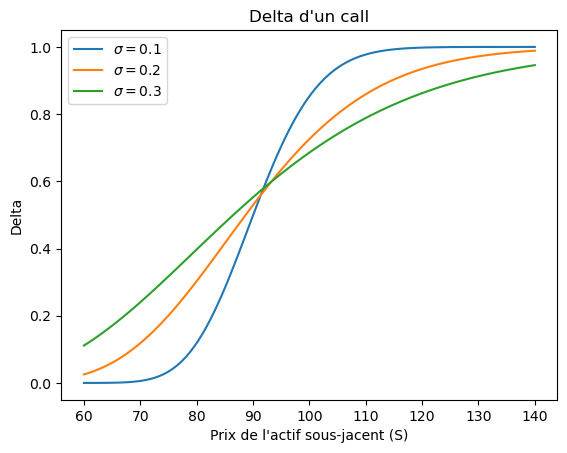

In [9]:
delta_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    delta_sigma = [delta_call(0, S, K, T, sigma, r, q) for S in S_values]
    delta_values.append(delta_sigma)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, delta_values[i], label=fr"$\sigma = {sigma}$")

plt.title(fr"Delta d'un call")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Delta')
plt.legend(); 

Pour un **call** : 
* $\Delta = 0.5$ signifie que $S = K$ autrement dit le call est $ATM$ (*at the money*).
* $\Delta < 0.5$ i.e. $S < K$, le call est $OTM$ (*out of the money*). Si $\Delta \approx 0$, le call est $DOTM$ (*deep out of the money*), et dans ce cas son prix sera très faible. 
* $\Delta > 0.5$ i.e $S > K$, le call est $ITM$ (*in the money*).  Si $\Delta \approx 1$, le call est $DITM$ (*deep in the money*), et dans ce cas son prix sera très élevé.

Ainsi, plus $\Delta$ est proche de $1$, plus l'option sera chère. 

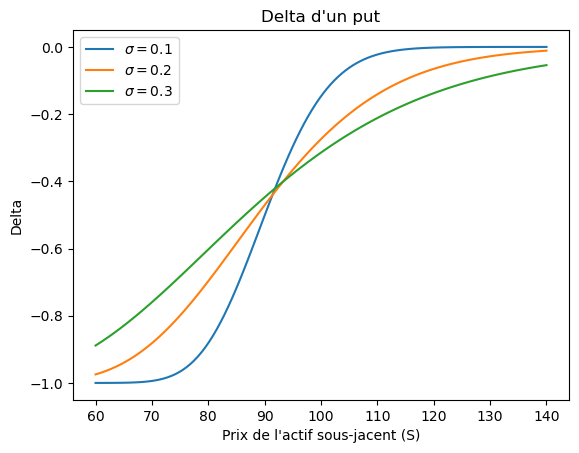

In [10]:
delta_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    delta_sigma = [delta_put(0, S, K, T, sigma, r, q) for S in S_values]
    delta_values.append(delta_sigma)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, delta_values[i], label=fr"$\sigma = {sigma}$")

plt.title("Delta d'un put")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Delta')
plt.legend(); 

Pour un **put** : 
* $\Delta = -0.5$ signifie que $S = K$ autrement dit le put est $ATM$ (*at the money*).
* $\Delta < -0.5$ i.e. $S < K$, le put est $ITM$ (*in the money*). Si $\Delta \approx -1$, le call est $DITM$ (*deep in the money*), et dans ce cas son prix sera très élevé.
* $\Delta > -0.5$ i.e $S > K$, le put est $OTM$ (*out the money*).  Si $\Delta \approx 0$, le put est $DOTM$ (*deep out of the money*), et dans ce cas son prix sera très faible. 

Ainsi, plus $\Delta$ est proche de $-1$, plus l'option sera chère. 

#### 1.3) Approximations par différences finies. <a id="part13"></a> 

En utilisant le fait que $$ f'(a) = \dfrac{f(a+h)-f(a-h)}{2h}+O\left(h^2\right),$$ 

et par régularité des fonctions $ S \rightarrow C(t,S),$ $S \rightarrow P(t,S),$

il vient que $$\Delta_{approx}^{call} = \dfrac{C(t,S+ds)-C(t,S)}{2ds}, $$ 

$$\Delta_{approx}^{put} = \dfrac{P(t,S+ds)-P(t,S)}{2ds}.$$ 

In [11]:
def delta_call_approx(t, S, K, T, sigma, r, q, ds) : 
    return (call(t, S+ds, K, T, sigma, r, q)-call(t, S-ds, K, T, sigma, r, q))/(2*ds)

In [12]:
def delta_put_approx(t, S, K, T, sigma, r, q, ds) : 
    return (put(t, S+ds, K, T, sigma, r, q)-put(t, S-ds, K, T, sigma, r, q))/(2*ds)

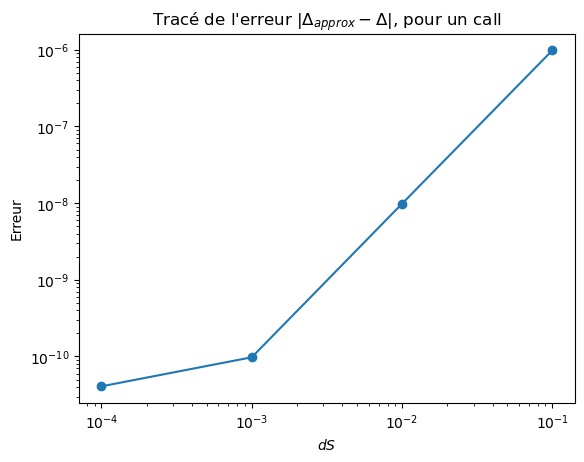

In [13]:
t = 0
S = 110
K = 100
T = 1
sigma = 0.2
r = 0.1
q = 0
errors_values = []
ds_values = [10**(-i) for i in range(1,5)]
for ds in ds_values : 
    val = np.abs(delta_call_approx(t, S, K, T, sigma, r, q, ds)-delta_call(t, S, K, T, sigma, r, q))
    errors_values.append(val)

plt.plot(ds_values, errors_values, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr"$dS$")
plt.ylabel('Erreur')
plt.title(fr"Tracé de l'erreur $|\Delta_{{approx}}-\Delta|$, pour un call")
plt.show()

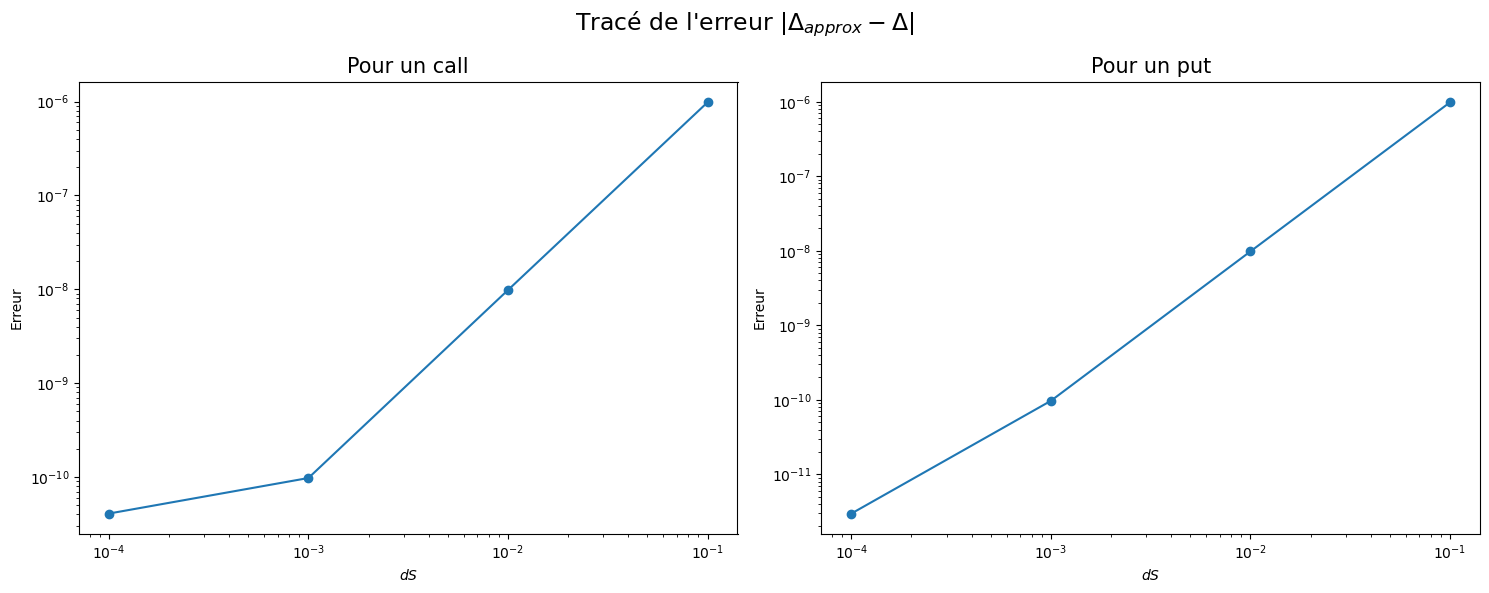

In [14]:
errors_values_call = []
ds_values = [10**(-i) for i in range(1, 5)]

for ds in ds_values:
    val = np.abs(delta_call_approx(t, S, K, T, sigma, r, q, ds) - delta_call(t, S, K, T, sigma, r, q))
    errors_values_call.append(val)

errors_values_put = []
for ds in ds_values:
    val = np.abs(delta_put_approx(t, S, K, T, sigma, r, q, ds) - delta_put(t, S, K, T, sigma, r, q))
    errors_values_put.append(val)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(ds_values, errors_values_call, marker='o')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$dS$")
axs[0].set_ylabel('Erreur')
axs[0].set_title(r"Pour un call", fontsize = 15)


axs[1].plot(ds_values, errors_values_put, marker='o')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$dS$")
axs[1].set_ylabel('Erreur')
axs[1].set_title("Pour un put", fontsize = 15)

plt.suptitle(fr"Tracé de l'erreur $|\Delta_{{approx}}-\Delta|$", fontsize = 17)
plt.tight_layout()
plt.show()

#### 1.4) $\Delta -$ hedging.<a id="part14"></a> 

L'objectif de cette section est de décrire la façon de se couvrir contre les mouvements de marché. 
Donnons quelques exemples.

* Si nous sommes en position longue sur un call, en tant que détenteur notre objectif est de prévenir contre une hausse du prix du cours de l'actif afin de pouvoir l'acheter au strike $K$. En revanche, si le cours de l'actif chute, le prix du call chute également et nous perdons de l'argent. Pour prévenir cette situation, nous **vendons à découvert** (c'est à dire en passant par un *broker*, et en déposant la moitié du prix de vente sur un *compte de marge*...) une quantité $\Delta$ de l'actif sous jacent. 

* Si nous sommes en position courte sur un call, en tant que détenteur notre objectif est de prévenir contre une baisse de prix du cours de l'actif, ce qui rendrait le call inintéressant. Afin de se couvrir contre cette éventuelle situation, nous allons acheter une quantité $\Delta$ de l'actif sous jacent. 

* Dans le cas d'un put, c'est l'inverse.

Ainsi, nous mettons en évidence 2 positions de couverture : 

* la **position courte** (*short hedge*), si la position du détenteur de l'option entraine en gain en cas de hausse et une perte en cas de baisse. 
* la **position longue** (*long hedge*), si la position du détenteur de l'option entraine une perte en cas de hausse et un gain en cas de baisse.

| Position sur l'option    |  Position de couverture    | Signe du $\Delta$         |
|--------------------------|----------------------------|----------------------------
| Longue sur un Call       | Courte                     |   $\Delta \geq 0$                | 
| Courte sur un Call       | Longue                     |   $\Delta \leq 0$                | 
| Longue sur un Put        | Longue                     |   $\Delta \leq 0$                | 
| Courte sur un Put        | Courte                     |   $\Delta \geq 0$                | 


L'objectif à présent est de choisir $\Delta$ telle que la valeur du portefeuille ne soit pas sensible aux petites variations du prix de l'actif sous jacent. Reprenons le cas d'une position longue sur un call. Les autres cas se traitent de manière analogue.

On a : $V(S) = C(S)-\Delta\times S.$ 

Supposons que le prix spot devient $S + dS$, où $dS << S$. Dans ce cas nous avons : 

$$V(S+dS)-V(S)=C(S+dS) -  C(S) - \Delta \times dS,$$ 

comme par hypothèse $V$ n'est pas sensible aux petites variations du spot : 

$$0 \approx C(S+dS) -  C(S) - \Delta \times dS.$$

En prenant $dS \rightarrow 0$ nous obtenons bien $ \Delta = \dfrac{\partial C}{\partial S}$.

Ainsi $\Delta(V) = \dfrac{\partial V}{\partial S} = 0$. Un tel portefeuille est appelé un portefeuille **$\Delta$ - neutre**.


> **Exemple:** Nous prenons une position longue sur $1000$ calls $ATM$ de prix $C_1$ de maturité $T = 0.5$, où $S = 100$, $q = 0$, $r = 0.05$, et $\sigma = 0.3$. Notons $S_1 = 100$.
>
> Le prix déboursé quant à l'achat de ces options est : `1000 * call(0, 100, 100, 0.5, 0.3, 0.05, 0)` $\approx 9634.88 \$ $.
>
> Afin de correctement couvrir notre portefeuille d'options, nous devons vendre à découvert $1000$ $\times$ $\Delta(C)$ unités de l'actif sous jacent, autrement dit : `1000 * norm.cdf(d_1(0, 100, 100, 0.5, 0.3, 0.05, 0))` $\approx 588.89$ unités.
> 
> Ce qui nous donne une valorisation du portefeuille de couverture de $ 1000C_1-589S_1 \approx  -49265.12 \$ $. 
> 
> Si par exemple le lendemain le cours de l'actif $S$ tombe à $S_2 := 98\$$. En notant $C_2 = $ `call(0, 98, 100, 125/252, 0.3, 0.05, 0)` $\approx 8.45 \$$, le valeur de notre portefeuille est : $1000C_2 - 589S_2 \approx -49268.88 \$ $.
>
> Ainsi, notre perte est de seulement $\left(1000C_2-589S_2\right)-\left(1000C_1-589S_1\right) \approx -3.74 \$ $. 
>
> Dans le cas où nous n'avons pas utilisé le *$\Delta$-hedging*, la perte serait de $1000(C_2-C_1) \approx -1181.75 \$ $.  

### 2) Le Gamma $\left(\Gamma\right)$.<a id="part2"></a>

Le $\Gamma$ représente la convexité d'une option en fonction du cours du sous-jacent. Il indique si le prix de l'option a tendance à évoluer plus ou moins vite que le prix du sous-jacent. Par analogie avec la physique, on peut considérer $\Delta$ comme la vitesse (dérivée 1ère), et $\Gamma$ comme l'accélération (dérivée seconde) : 

$$ \boxed {\Gamma(V) = \dfrac{\partial^2V}{\partial S^2}}$$ 

Une autre interprétation du Gamma est le sens de l'évolution du Delta en fonction du prix du sous-jacent : 
* $\Gamma \geq 0$ indique que $S$ et $\Delta$ évoluent dans le même sens.
* $\Gamma \leq 0$ indique le contraire. 

#### 2.1) Calcul pour un call / put. <a id="part21"></a> 

Nous avons précédemment montré que : 
$$ \Delta(C_t) = \text{e}^{-q(T-t)}\mathcal{N}(d_1).$$

Alors, 

$$ \Gamma(C_t) = \dfrac{\partial^2 C_t}{\partial S^2} = \dfrac{\partial \Delta(C_t)}{\partial S} = \text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial S}.$$

En notant que $\dfrac{\partial d_1}{\partial S} = \dfrac{1}{S\sigma\sqrt{T-t}}$, nous obtenons : 

$$ \Gamma(C_t) = \dfrac{\text{e}^{-q(T-t)}}{S\sigma\sqrt{T-t}}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}.$$ 

De même, la relation de parité call / put dérivée deux fois par rapport à S implique : 

$$ \Gamma(P_t) = \Gamma(C_t) = \dfrac{\text{e}^{-q(T-t)}}{S\sigma\sqrt{T-t}}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}. $$

#### 2.2) Implémentation. <a id="part22"></a> 

In [15]:
def gamma(t, S, K, T, sigma, r, q) : 
    return np.exp(-q*(T-t))/(S*sigma*np.sqrt(T-t))*1/(np.sqrt(2*np.pi))*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)

In [16]:
sigmas = [0.025,0.05,0.1, 0.2, 0.3]
K = 100
T = 1 
r = 0.1 
q = 0

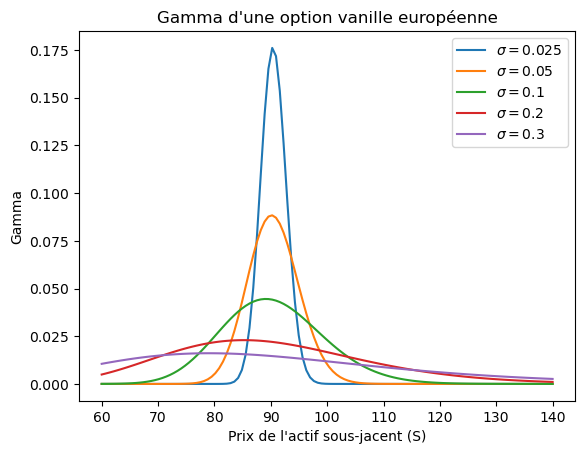

In [17]:
gamma_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    gamma_sigma = [gamma(0, S, K, T, sigma, r, q) for S in S_values]
    gamma_values.append(gamma_sigma)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, gamma_values[i], label=fr"$\sigma = {sigma}$")

plt.title(fr"Gamma d'une option vanille européenne")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Gamma')
plt.legend(); 

Le gamma est maximal pour $S \approx K$, autrement dit pour les options qui sont (ou presque), $ATM$.  Cela signifie que de petites variations dans le prix de l'actif sous-jacent entraînent des changements significatifs du delta. Au contraire, dès que $S$ s'éloigne de $K$ (que ce soit $OTM$ ou $ITM$, de toute façon cela s'inverse avec call / put), le gamme est (très) proche de $0$. Dans ce cas, les variations du spot $S$ ont peu d'influence sur le delta (il change lentement) : l'option est alors moins sensible aux variations du prix spot. Démontrons ces affirmations dans la section suivante.  

#### 2.3) Maximalité pour les options ATM. <a id="part23"></a> 

Nous allons montrer que, en tant que fonction de $S$, $\Gamma(S)$ est maximale pour $S = K$ et que $\lim_{S \to 0_+} \Gamma(S) = \lim_{S \to +\infty} \Gamma(S) = 0.$

On rapelle que $\Gamma(S) = \dfrac{\text{e}^{-q(T-t)}}{S\sigma\sqrt{T-t}}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}} > 0$. Ainsi $\Gamma(S)$ et $\ln\left(\Gamma(S)\right)$ ont les mêmes variations. 

Cela nous amène à considérer $f : \mathbb{R}+_* \rightarrow \mathbb{R},$ où $f(S) = \ln\left(\Gamma(S)\right)$. 
Remarquons que $\Gamma(S)$ peut s'écrire sous la forme 

$$\Gamma(S) = \dfrac{1}{\sigma\sqrt{2\pi T}}\exp\left(-\dfrac{d_1(S)^2}{2}-\ln(S)-q(T-t)\right).$$

$$\Rightarrow \ln\left(\Gamma(S)\right) = -\dfrac{d_1(S)^2}{2}-\ln(S)-q(T-t)-\ln\left(\sigma\sqrt{2\pi T}\right)$$

On a : 

$$f'(S) = -d_1(S)\dfrac{\partial d_1(S)}{\partial S}-\dfrac{1}{S} = -\dfrac{d_1(S)}{S\sigma \sqrt{T}}-\dfrac{1}{S} = -\dfrac{1}{S}\left(1+\dfrac{d_1(S)}{\sigma \sqrt{T}}\right).$$ 

Il est facile de remarquer qu'en vertu de la définition de $d_1$ que : 
$\begin{cases}
\lim_{S \to 0_+} d_1 = -\infty \\
\lim_{S \to +\infty} d_1 = +\infty
\end{cases}.$

Par stricte monotonie (ici stricte croissance) et continuité de $d_1$, on a finalement que par le théorème des valeurs intermédiaires l'existence d'un unique $S^*$ tel que : 

$$d_1(S^*) = -\sigma \sqrt{T},$$

de telle sorte que $S^*$ soit l'unique point critique de la fonction $f$. 

On en déduit alors immédiatement que : 
$\begin{cases}
f'(S) > 0& \text{si } 0 < S < S^* \\
f'(S) < 0& \text{si } S^* < S
\end{cases}.$
Ainsi, $f$ est croissante, atteint son maximum, puis décroît. Il en est ainsi de même pour $\Gamma(S)$, dont le maximum est bien atteint en $S = S^*$. Explicitement : 

$$S^* = K \exp\left(\dfrac{\sigma^2}{2}T+q-r \right) $$

> **Exemple :** Dans le cadre de 2.1, nous avons calculé le gamma pour $K = 100$, $ T = 1$, $\sigma = 0.025$, $r = 0.1$ et $q = 0$. Le gamma maximal pour cette option est atteint lorsque le spot est valorisé à : 
>
>$$100\times \exp\left(\dfrac{0.000625}{2}-0.1\right) \approx  
90.512. $$

Reste à voir que lorsque l'option est $DOTM$ ou $DITM$, le gamma est asymptotiquement petit. En raison du fait que
$\lim_{S \to +\infty} d_1 = +\infty$, il vient que 

$$\lim_{S \to +\infty} \Gamma(S) = \lim_{S \to \infty} \dfrac{1}{\sigma\sqrt{2\pi T}}\exp\left(-\dfrac{d_1(S)^2}{2}-\ln(S)-q(T-t)  \right) = 0.$$ 

D'autre part : 

$$ \lim_{S \to 0_+} \dfrac{-\dfrac{d_1(S)^2}{2}-\ln(S)}{-\ln^2(S)} = \lim_{S \to 0_+} \left(\dfrac{\left(\ln(S)-\ln(K)+\left(r-q+\frac{\sigma^2}{2}\right)T    \right)^2}{2\sigma^2T\ln^2(S)} + \dfrac{1}{\ln(S)}      \right) = \dfrac{1}{2\sigma^2T}.$$

Ainsi, 

$$ \lim_{S \to 0_+} \exp \left( -\dfrac{d_1(S)^2}{2}-\ln(S)\right) = 0.$$ 

Donc finalement $\lim_{S \to 0_+} \Gamma(S) = 0 $.

#### 2.4) Approximations par différences finies. <a id="part24"></a> 

En utilisant le fait que $$ f''(a) = \dfrac{f(a+h)-2f(a)+f(a-h)}{h^2} + O\left(h^2\right),$$

et par régularité de la fonction $S \rightarrow C(t, S) : $

$$\Gamma_{approx} = \dfrac{C(t, S+ds) - 2C(t, S) + C(t, S-ds)}{(ds)^2}$$ 

In [18]:
def gamma_approx(t, S, K, T, sigma, r, q, ds) : 
    forward = call(t, S+ds, K, T, sigma, r, q)
    backward = call(t, S-ds, K, T, sigma, r, q)
    current = call(t, S, K, T, sigma, r, q)
    return (forward-2*current+backward)/(ds)**2

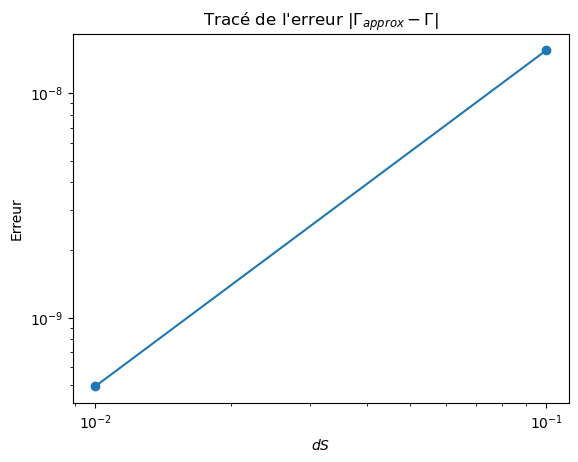

In [19]:
t = 0
S = 110
K = 100
T = 1
sigma = 0.2
r = 0.1
q = 0
errors_values = []
ds_values = [10**(-i) for i in range(1,3)]
for ds in ds_values : 
    val = np.abs(gamma_approx(t, S, K, T, sigma, r, q, ds)-gamma(t, S, K, T, sigma, r, q))
    errors_values.append(val)

plt.plot(ds_values, errors_values, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr"$dS$")
plt.ylabel('Erreur')
plt.title(fr"Tracé de l'erreur $|\Gamma_{{approx}}-\Gamma|$")
plt.show()

**Remarque:** L'approximation d'ordre 2 centrée est suffisamment précise pour donner une erreur faible, même pour un $dS$ grand. 

#### 2.5) $\Gamma - $ hedging. <a id="part25"></a> 

Dans la section 1.4 nous avons présenté le $\Delta$ - hedging, dont l'objectif était de neutraliser la sensibilité du portefeuille aux mouvements de prix du sous-jacent. Cependant, comme le $\Delta$ change avec le prix du sous-jacent (c'est là que le $\Gamma$ entre en jeu), des ajustements fréquents sont nécessaires pour maintenir une couverture $\Delta$ - efficace. Le $\Gamma$ - hedging va apporter une converture supplémentaire, afin de se protéger contre les changements de $\Delta$, en ajustant les positions dans d'autres options pour que le gamma du portefeuille soit proche de zéro.

> **Exemple :** Supposons que $\Delta(V) = 300$, $\Gamma(V) = 100$. Nous avons : 
>
> $$\begin{cases}
\Delta(C) = 0.2 \\
\Gamma(C) = 0.1
\end{cases}, \,\,\,\, \begin{cases}
\Delta(P) = -0.8\\
\Gamma(P) = 0.3
\end{cases}.$$ 
>
> Construisons $V_{neutral}$, un portefeuille $\Delta$ et $\Gamma$ neutre. Autrement dit déterminer $x_1, x_2, x_3$ tels que : 
>
> $$V_{neutral} = V + x_1\times S +x_2 \times C+ x_2 \times P$$
>
> $$\begin{cases}
\Delta\left(V_{neutral}\right) = \Delta(V) + x_1 + x_2 \Delta(C) + x_3 \Delta(P) = 0 \\
\Gamma\left(V_{neutral}\right) = \Gamma(V) + x_2 \Gamma(C) + x_3 \Gamma(P) = 0
\end{cases} 
\Leftrightarrow 
\begin{cases} 
x_1 = -254 \\
x_2 = -670 \\
x_3 = -110 
\end{cases},$$ 
>
> C'est à dire vendre $254$ unités de l'actif sous jacent, vendre $670$ calls, et enfin vendre $110$ puts. 

### 3) Le Thêta $\left(\Theta\right)$.<a id="part3"></a>

Le $\Theta$ est le coût (ou le gain) du temps qui passe sur le portefeuille $V$. Ce dernier permet d'évaluer combien le passage du temps influe sur la valeur d'une option. Pour l'instant, définissons le ainsi : 

$$\boxed {\Theta(V) = \dfrac{\partial V}{\partial t}}$$ 

L'inconvénient de cette définition c'est qu'elle pose problème lors du calcul avec $t = 0$. En effet, on obtiendrait $\Theta(V) = 0$, puisque cette quantité ne dépend pas de $t$ (puisqu'il est prit au temps $0$). 
Nous pouvons ainsi le voir comme : 

$$ \Theta(V) = \dfrac{\partial V}{\partial t}\bigg |_{\,t=0}.$$ 

L'interprétation correcte pour $\Theta$ est le taux de variation de la valeur de l'option par rapport au temps restant jusqu'à l'échéance $T-t$. En appliquant la règle de chaine : 

$$\Theta(V) = \dfrac{\partial V}{\partial (T-t)} \cdot \dfrac{\partial (T-t)}{\partial t} = -\dfrac{\partial V}{\partial(T-t)}.$$

Enfin, une dernière façon de définir $\Theta$ est la suivante : 

$$\Theta(V) = -\dfrac{\partial V}{\partial T}.$$

En effet, $\dfrac{\partial V}{\partial T} = \dfrac{\partial V}{\partial(T-t)} \cdot \dfrac{\partial (T-t)}{\partial T} = \dfrac{\partial V}{\partial(T-t)}.$

#### 3.1) Calcul pour un call / put. <a id="part31"></a> 

On sait que $C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2).$

$$\dfrac{\partial C_t}{\partial (T-t)} = -qS_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) + S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial (T-t)} + rK\text{e}^{-r(T-t)}\mathcal{N}(d_2)-K\text{e}^{-r(T-t)}\mathcal{N}'(d_2)\dfrac{\partial d_2}{\partial (T-t)}$$

$$\Leftrightarrow \dfrac{\partial C_t}{\partial (T-t)} = -qS_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) + S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\left(\dfrac{\partial d_1}{\partial (T-t)}-\dfrac{\partial d_2}{\partial (T-t)}\right)+ rK\text{e}^{-r(T-t)}\mathcal{N}(d_2),$$

en utilisant $(\star)$. 

En notant que $d_1 - d_2 = \sigma\sqrt{T-t}$, il vient que $ \dfrac{\partial d_1}{\partial (T-t)}-\dfrac{\partial d_2}{\partial (T-t)} = \dfrac{\sigma}{2\sqrt{T-t}}$. 

Donc : 

$$ \dfrac{\partial C_t}{\partial (T-t)} = -qS_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) + S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\sigma}{2\sqrt{T-t}}+ rK\text{e}^{-r(T-t)}\mathcal{N}(d_2).$$ 

Finalement, $\Theta(C_t) = -\dfrac{\partial C_t}{\partial (T-t)} = qS_t\text{e}^{-q(T-t)}\mathcal{N}(d_1)-\dfrac{1}{\sqrt{2\pi}}S_t\text{e}^{-q(T-t)}\dfrac{\sigma}{2\sqrt{T-t}}\text{e}^{-\frac{d_1^2}{2}} - rK\text{e}^{-r(T-t)}\mathcal{N}(d_2).$

En utilisant la parité call / put : 
$$P_t + S_t\text{e}^{-q(T-t)} - C_t = K\text{e}^{-r(T-t)} $$

$$\Theta(P_t) = \Theta(C_t) +rK\text{e}^{-r(T-t)} -qS_t\text{e}^{-q(T-t)} = qS_t\text{e}^{-q(T-t)}\left(\mathcal{N}(d_1)-1\right)-\dfrac{1}{\sqrt{2\pi}}S_t\text{e}^{-q(T-t)}\dfrac{\sigma}{2\sqrt{T-t}}\text{e}^{-\frac{d_1^2}{2}} - rK\text{e}^{-r(T-t)}\left(\mathcal{N}(d_2)-1\right)$$

Comme $1-\mathcal{N}(d_1) = \mathcal{N}(-d_1),$ il vient que : 

$$\Theta(P_t) = -qS_t\text{e}^{-q(T-t)}\mathcal{N}(-d_1)-\dfrac{1}{\sqrt{2\pi}}S_t\text{e}^{-q(T-t)}\dfrac{\sigma}{2\sqrt{T-t}}\text{e}^{-\frac{d_1^2}{2}} + rK\text{e}^{-r(T-t)}\mathcal{N}(-d_2).$$

#### 3.2) Implémentation. <a id="part32"></a> 

In [20]:
S_values = [80,100,120]

In [21]:
def theta_call(t, S, K, T, sigma, r, q) : 
    if T == t:
        T = t + 1e-6
    else : 
        return q*S*np.exp(-q*(T-t))*norm.cdf(d_1(t, S, K, T, sigma, r, q))-1/(np.sqrt(2*np.pi))*S*np.exp(-q*(T-t))*sigma/(2*np.sqrt(T-t))*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)-r*K*np.exp(-r*(T-t))*norm.cdf(d_2(t, S, K, T, sigma, r, q))

In [22]:
def theta_put(t, S, K, T, sigma, r, q) : 
    if T == t:
        T = t + 1e-6 
    else : 
        return -q*S*np.exp(-q*(T-t))*norm.cdf(-d_1(t, S, K, T, sigma, r, q))-1/(np.sqrt(2*np.pi))*S*np.exp(-q*(T-t))*sigma/(2*np.sqrt(T-t))*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)+r*K*np.exp(-r*(T-t))*norm.cdf(-d_2(t, S, K, T, sigma, r, q))

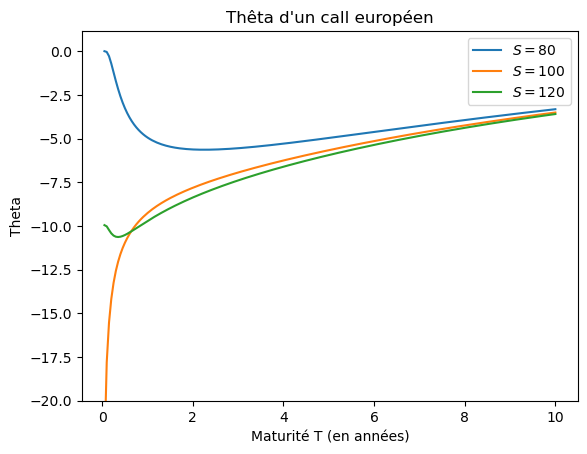

In [23]:
thetas_values = []
T_values = np.linspace(0,10,200)

for S in S_values:
    t = [theta_call(0, S, K, T, sigma, r, q) for T in T_values]
    thetas_values.append(t)

for i, s in enumerate(S_values):
    plt.plot(T_values, thetas_values[i], label=fr"$S = {s}$")

plt.title(fr"Thêta d'un call européen")
plt.xlabel('Maturité T (en années)')
plt.ylim(-20)
plt.ylabel('Theta')
plt.legend(); 

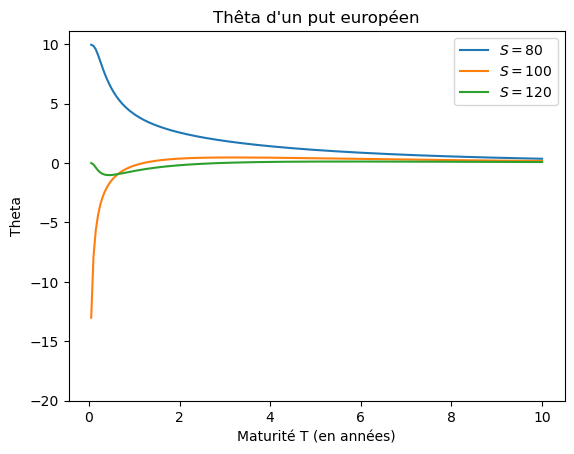

In [24]:
thetas_values = []
T_values = np.linspace(0,10,200)

for S in S_values:
    t = [theta_put(0, S, K, T, sigma, r, q) for T in T_values]
    thetas_values.append(t)

for i, s in enumerate(S_values):
    plt.plot(T_values, thetas_values[i], label=fr"$S = {s}$")

plt.title(fr"Thêta d'un put européen")
plt.xlabel('Maturité T (en années)')
plt.ylim(-20)
plt.ylabel('Theta')
plt.legend(); 

#### 3.3) Approximations par différences finies. <a id="part33"></a> 

En utilisant le fait que $$ f'(a) = \dfrac{f(a+h)-f(a-h)}{2h}+O\left(h^2\right),$$ 

et par régularité des fonctions $ T \rightarrow C(t,S,T),$ $T \rightarrow P(t,S,T),$

$$\Theta_{approx}^{call} = - \dfrac{C(t, S, T+dt)-C(t,S,T)}{dT},$$ 

$$\Theta_{approx}^{put} = - \dfrac{P(t, S, T+dt)-P(t,S,T)}{dT},$$ 

In [27]:
def theta_call_approx(t, S, K, T, sigma, r, q, dT) : 
    forward = call(t, S, K, T + dT, sigma, r, q)
    current = call(t, S, K, T, sigma, r, q)
    return -(forward-current)/dT

In [28]:
theta_call_approx(0, 20,18, 0.5, 0.2, 0.05, 0, 1e-12)

-1.3926637620897964

In [29]:
def theta_put_approx(t, S, K, T, sigma, r, q, dT) : 
    forward = put(t, S, K, T + dT, sigma, r, q)
    current = put(t, S, K, T, sigma, r, q)
    return -(forward-current)/dT

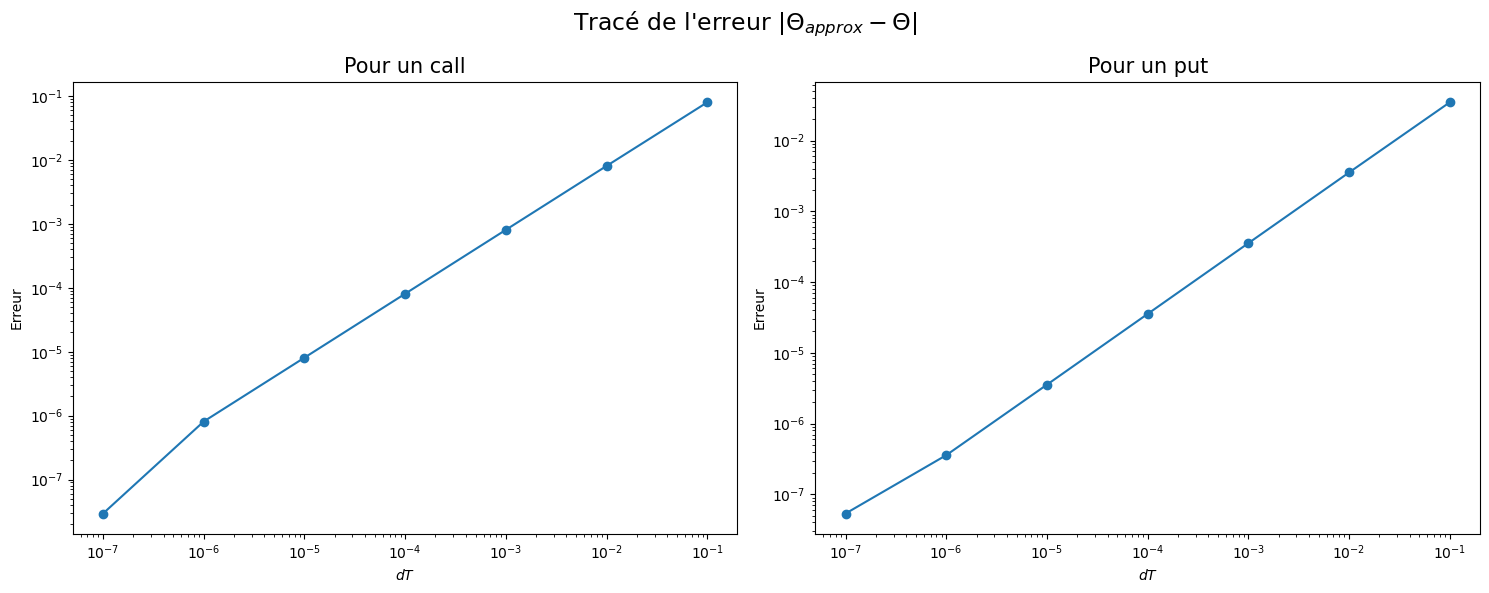

In [30]:
t = 0
errors_values_call = []
dT_values = [10**(-i) for i in range(1, 8)]

for dT in dT_values:
    val = np.abs(theta_call_approx(t, S, K, T, sigma, r, q, dT) - theta_call(t, S, K, T, sigma, r, q))
    errors_values_call.append(val)

errors_values_put = []
for dT in dT_values:
    val = np.abs(theta_put_approx(t, S, K, T, sigma, r, q, dT) - theta_put(t, S, K, T, sigma, r, q))
    errors_values_put.append(val)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(dT_values, errors_values_call, marker='o')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$dT$")
axs[0].set_ylabel('Erreur')
axs[0].set_title(r"Pour un call", fontsize = 15)


axs[1].plot(dT_values, errors_values_put, marker='o')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$dT$")
axs[1].set_ylabel('Erreur')
axs[1].set_title("Pour un put", fontsize = 15)

plt.suptitle(fr"Tracé de l'erreur $|\Theta_{{approx}}-\Theta|$", fontsize = 17)
plt.tight_layout()
plt.show()

### 4) Le Rhô $\left(\rho\right)$.<a id="part4"></a>

Le $\rho$ est le taux de variation de la valeur de portefeuille $V$ en fonction du taux sans risque $r$. Il est défini comme : 

$$ \boxed {\rho(V) = \dfrac{\partial V}{\partial r}}$$

#### 4.1) Calcul pour un call / put. <a id="part41"></a> 

On sait que $C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2).$

Ainsi : 
    
$$\rho(C_t) = \dfrac{\partial C_t}{\partial r}  = S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial r} +K(T-t)\text{e}^{-r(T-t)}\mathcal{N}(d_2) - K\text{e}^{-r(T-t)}\mathcal{N}'(d_2)\dfrac{\partial d_2}{\partial r}$$ 

$$\rho(C_t) = S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\left(\dfrac{\partial d_1}{\partial r} - \dfrac{\partial d_2}{\partial r}\right) +K(T-t)\text{e}^{-r(T-t)}\mathcal{N}(d_2),$$

en utilisant ($\star$). 

Finalement comme la différence $d_1-d_2$ ne dépend pas du taux sans risque : 

$$\rho(C_t) = K(T-t)\text{e}^{-r(T-t)}\mathcal{N}(d_2)$$

Toujours par la relation de parité call / put : 

$$\rho(P_t) = \rho(C_t) -(T-t)K\text{e}^{-r(T-t)} = -K(T-t)\text{e}^{-r(T-t)}\mathcal{N}(-d_2),$$

par le fait que $1-\mathcal{N}(d_2) = \mathcal{N}(-d_2).$

#### 4.2) Implémentation. <a id="part42"></a> 

In [31]:
def rho_call(t, S, K, T, sigma, r, q) : 
    return K*(T-t)*np.exp(-r*(T-t))*norm.cdf(d_2(t, S, K, T, sigma, r, q))

rho_call(0,100,100,1,0.3,0.05, 0)

48.193918004615426

In [32]:
def rho_put(t, S, K, T, sigma, r, q) : 
    return -K*(T-t)*np.exp(-r*(T-t))*norm.cdf(-d_2(t, S, K, T, sigma, r, q))

In [33]:
T = 1
sigma = 0.2
q = 0

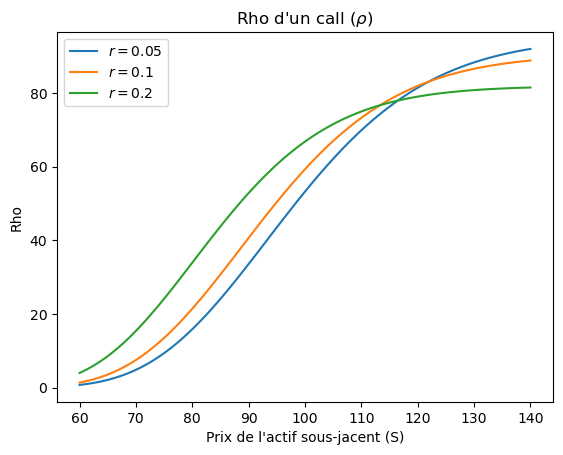

In [34]:
r_values = [0.05, 0.1, 0.2]
rho_values = []

S_values = np.linspace(60,140,120)

for r in r_values:
    rho = [rho_call(0, S, K, T, sigma, r, q) for S in S_values]
    rho_values.append(rho)

for i, r in enumerate(r_values):
    plt.plot(S_values, rho_values[i], label=fr"$r = {r}$")

plt.title(fr"Rho d'un call ($\rho$)")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Rho')
plt.legend(); 

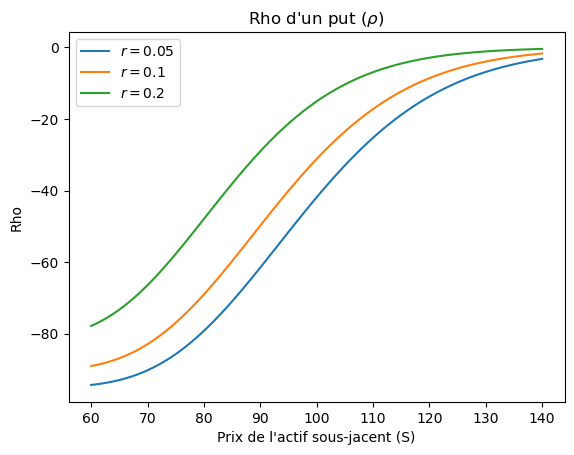

In [35]:
r_values = [0.05, 0.1, 0.2]
rho_values = []

S_values = np.linspace(60,140,120)

for r in r_values:
    rho = [rho_put(0, S, K, T, sigma, r, q) for S in S_values]
    rho_values.append(rho)

for i, r in enumerate(r_values):
    plt.plot(S_values, rho_values[i], label=fr"$r = {r}$")

plt.title(fr"Rho d'un put ($\rho$)")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Rho')
plt.legend(); 

#### 4.3) Approximations par différences finies. <a id="part43"></a> 

En utilisant le fait que $$ f'(a) = \dfrac{f(a+h)-f(a-h)}{2h}+O\left(h^2\right),$$ 
et par régularité des fonctions $r \rightarrow C(t, S, r)$, $r \rightarrow P(t, S, r)$ : 

$$\rho_{approx}^{call} = \dfrac{C(t, S, r+dr)-C(t,S,r)}{dr},$$ 

$$\rho_{approx}^{put} = \dfrac{P(t, S, r+dr)-P(t , S, r)}{dr}.$$ 

In [39]:
def rho_call_approx(t, S, K, T, sigma, r, q, dr) : 
    forward = call(t, S, K, T, sigma, r + dr, q)
    current = call(t, S, K, T, sigma, r, q)
    return (forward-current)/dr 

In [40]:
def rho_put_approx(t, S, K, T, sigma, r, q, dr) : 
    forward = put(t, S, K, T, sigma, r + dr, q)
    current = put(t, S, K, T, sigma, r, q)
    return (forward-current)/dr 

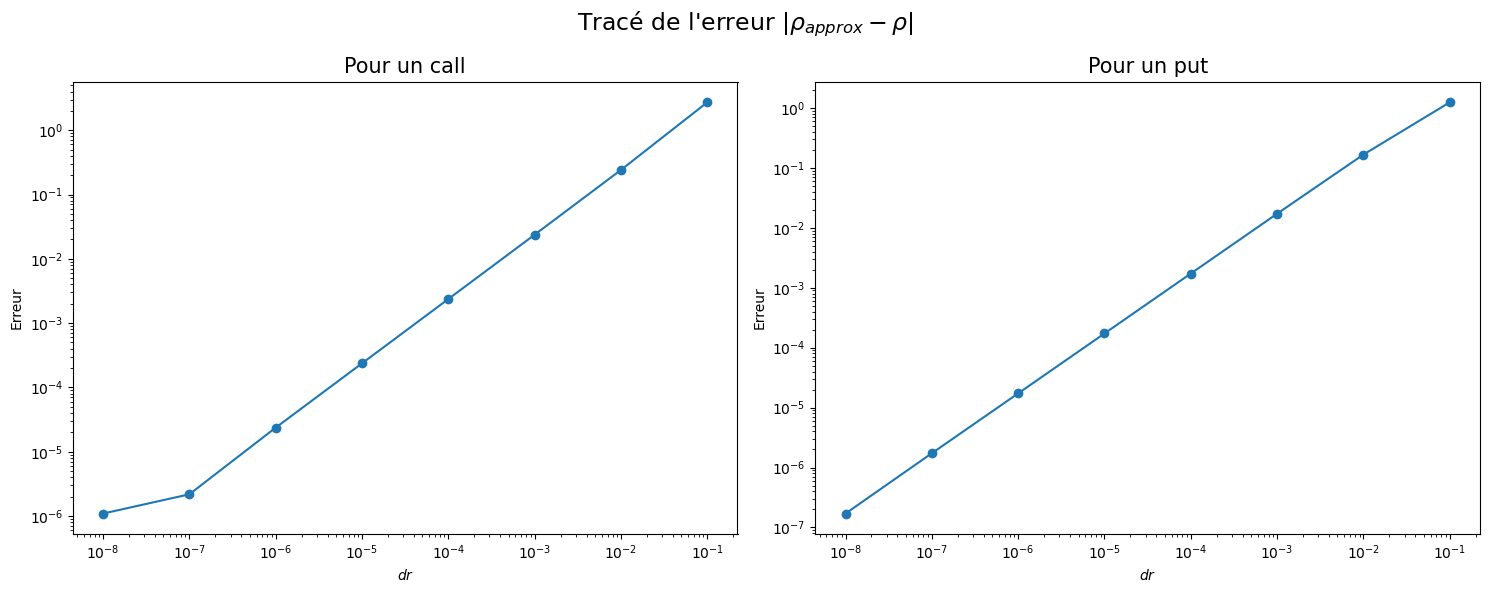

In [41]:
t = 0
errors_values_call = []
dr_values = [10**(-i) for i in range(1, 9)]

for dr in dr_values:
    val = np.abs(rho_call_approx(t, S, K, T, sigma, r, q, dr) - rho_call(t, S, K, T, sigma, r, q))
    errors_values_call.append(val)

errors_values_put = []
for dr in dr_values:
    val = np.abs(rho_put_approx(t, S, K, T, sigma, r, q, dr) - rho_put(t, S, K, T, sigma, r, q))
    errors_values_put.append(val)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(dr_values, errors_values_call, marker='o')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$dr$")
axs[0].set_ylabel('Erreur')
axs[0].set_title(r"Pour un call", fontsize = 15)


axs[1].plot(dr_values, errors_values_put, marker='o')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$dr$")
axs[1].set_ylabel('Erreur')
axs[1].set_title("Pour un put", fontsize = 15)

plt.suptitle(fr"Tracé de l'erreur $|\rho_{{approx}}-\rho|$", fontsize = 17)
plt.tight_layout()
plt.show()

### 5) Le Vega $\left(\text{Vega}\right)$.<a id="part5"></a>

Le $\text{vega}$ (on peut le trouver avec la notation $\nu$) mesure la sensibilité à la volatilité. Il s'exprime comme : 

$$ \boxed {\text{vega}(V) = \dfrac{\partial V}{\partial \sigma}}$$

#### 5.1) Calcul pour un call / put. <a id="part51"></a> 

On sait que $C_t = S_t\text{e}^{-q(T-t)}\mathcal{N}(d_1) - K\text{e}^{-r(T-t)}\mathcal{N}(d_2).$

Ainsi : 
$$\text{vega}(C_t) = S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\dfrac{\partial d_1}{\partial \sigma} - K\text{e}^{-r(T-t)}\mathcal{N}'(d_2)\dfrac{\partial d_2}{\partial \sigma}$$   

$$\Leftrightarrow \text{vega}(C_t) = S_t\text{e}^{-q(T-t)}\mathcal{N}'(d_1)\left(\dfrac{\partial d_1}{\partial \sigma}-\dfrac{\partial d_2}{\partial \sigma}\right)$$

$$\Leftrightarrow \text{vega}(C_t) = \dfrac{1}{\sqrt{2\pi}}S\text{e}^{-q(T-t)}\text{e}^{-\frac{d_1^2}{2}}\sqrt{T-t}$$

Le relation de parité call / put est la suivante : $P_t + S_t\text{e}^{-q(T-t)}-C_t = K\text{e}^{-r(T-t)} $, ce qui implique directement (en dérivant par rapport à $\sigma$ de chaque côté) que : 

$$ \text{vega}(P_t) = \text{vega}(C_t).$$

#### 5.2) Implémentation et croissance en fonction de la maturité. <a id="part52"></a> 

In [42]:
def vega(t, S, K, T, sigma, r, q) : 
    if(T == t) : # Afin d'éviter la division par 0. 
        T = t + 1e-6
    return 1/np.sqrt(2*np.pi)*S*np.exp(-q*(T-t))*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)*np.sqrt(T-t)

In [43]:
S_values = [80,100, 120]
K = 100
T = 1
r = 0.1 
q = 0 
sigmas = [0.1,0.2,0.3]

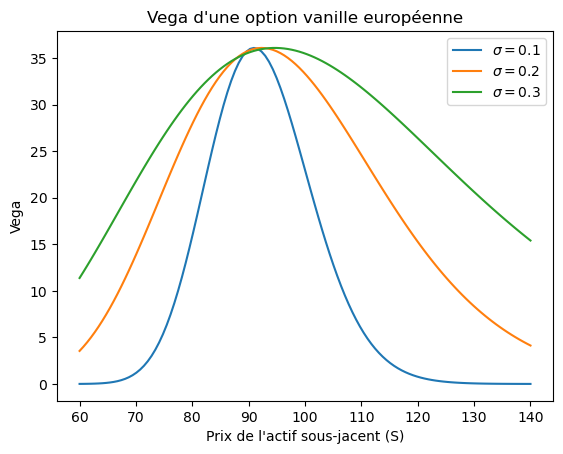

In [44]:
vega_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    v = [vega(0, S, K, T, sigma, r, q) for S in S_values]
    vega_values.append(v)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, vega_values[i], label=fr"$\sigma = {sigma}$")

plt.title(fr"Vega d'une option vanille européenne")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Vega')
plt.legend(); 

On observe que (comme dans le cas du $\Gamma$), $\text{vega}$ est maximal lorsque l'option est $ATM$ ($S = K$).  Cela se produit parce que les petites variations de la volatilité ont le plus grand impact sur les options qui ont une probabilité à peu près égale de finir $ITM$ ou $OTM$.

La même démonstration que pour le gamma (cf. 2.3) vaut pour le $\text{vega}$. On trouve également que le maximum est atteint en 

$$ S^* = K\exp \left(\dfrac{\sigma^2}{2}T+q-r \right).$$

> **Exemple:** Dans le cas d'une option de strike $K = 100$, $T = 1$, $\sigma = 0.3$, $r = 0.1$ et $q = 0$, on trouve que le maximum est réalisé lorsque le spot est valorisé à : 
>
>$$100 \times \exp\left(\dfrac{0.3^2}{2}-0.1 \right) \approx94.649. $$

Précédemment, nous avons examiné le $\text{vega}$ en fonction du prix du sous-jacent $S$. Il est également pertinent de s'intéresser à l'impact des variations de la maturité.

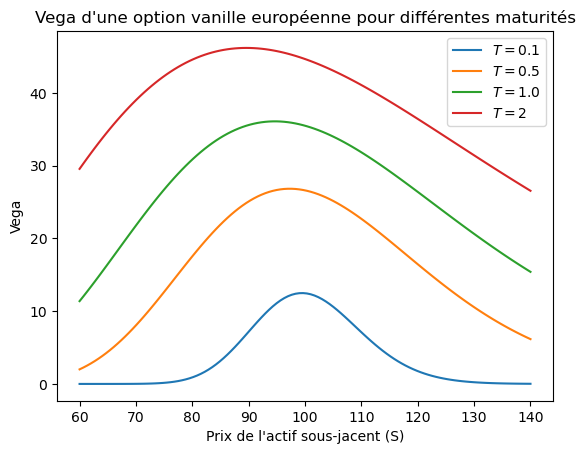

In [45]:
K = 100
sigma = 0.3
r = 0.1
q = 0
S_values = np.linspace(60,140,120)
T_values = [0.1, 0.5, 1.0,2]

vega_values = []
for T in T_values:
    vega_s = [vega(0, S, K, T, sigma, r, q) for S in S_values]
    vega_values.append(vega_s)

for i, T in enumerate(T_values):
    plt.plot(S_values, vega_values[i], label=fr"$T = {T}$")

plt.title("Vega d'une option vanille européenne pour différentes maturités")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Vega')
plt.legend();

On remarque que plus la maturité est lointaine, plus $\text{vega}$ est élevé (contrairement au $\Theta$ et au $\Gamma$). Cela s'explique par le fait que si l'option expire dans peu de temps, la volatilité affectera moins le prix des options. C'est ce que nous allons démontrer. 

Pour des raisons de clarté, nous prenons une option $ATM$, avec $r = q = 0$. Montrons que $\dfrac{\partial \, \text{vega}(V)}{\partial(T-t)} \geq 0$. 

Dans ce cas particulier, $d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}} = \dfrac{\sigma \sqrt{T-t}}{2}$, et $\text{vega}(V) = S\sqrt{T-t}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}$. 

Par la règle de chaine : 

$$\dfrac{\partial \, \text{vega}(V)}{\partial (T-t)} = S\dfrac{1}{2\sqrt{T-t}}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}} - S\sqrt{T-t}\dfrac{1}{\sqrt{2\pi}}d_1\text{e}^{-\frac{d_1^2}{2}}\dfrac{\partial d_1}{\partial(T-t)}$$

$$ \Leftrightarrow \dfrac{\partial \, \text{vega}(V)}{\partial (T-t)} = S\dfrac{1}{2\sqrt{T-t}}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}} - S\dfrac{T-t}{\sqrt{2\pi}}\dfrac{\sigma}{2}\text{e}^{-\frac{d_1^2}{2}}\dfrac{\sigma}{2}\dfrac{1}{2\sqrt{T-t}}$$

$$ \Leftrightarrow \dfrac{\partial \, \text{vega}(V)}{\partial (T-t)} = \dfrac{S}{2 \sqrt{2\pi(T-t)}}\text{e}^{-\frac{d_1^2}{2}}-\dfrac{\sigma^2S\sqrt{T-t}}{8\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}$$ 

$$ \Leftrightarrow \dfrac{\partial \, \text{vega}(V)}{\partial (T-t)} = \dfrac{S}{2\sqrt{2\pi(T-t)}}\left (1-\dfrac{\sigma^2(T-t)}{4} \right)\text{e}^{-\frac{d_1^2}{2}}$$

Ainsi, $$\dfrac{\partial \, \text{vega}(V)}{\partial (T-t)} \geq 0$$

$$\Leftrightarrow 1-\dfrac{\sigma^2(T-t)}{4} \geq 0$$ 

$$ \Leftrightarrow \dfrac{4}{\sigma^2} \geq T-t,$$

qui est remplie pour des volatilités, maturités raisonnables ($0.15 \leq \sigma \leq 0.5$), comme nous allons le voir dans l'exemple ci-dessous. 

> **Exemple:** Dans le cas où la volatilité est de $10 \%$ par an (typiquement dans le cas des devises), on trouve 
> 
> $$\dfrac{4}{\sigma^2} = 400,$$
> Donc pour $T \leq 400$ années, le vega de l'option est croissant. 
>
> Par ailleurs si $\sigma = 0.6$ (ce qui peut se produire pour les marchés volatils), 
>
> $$\dfrac{4}{\sigma^2} \approx 11.1$$
> Donc pour $T \leq 11$ années, le vega de l'option est croissant. 

#### 5.3) Approximations par différences finies. <a id="part53"></a> 

En utilisant le fait que $$ f'(a) = \dfrac{f(a+h)-f(a-h)}{2h}+O\left(h^2\right),$$

et par régularité de la fonction $\sigma \in\,]0,1[ \rightarrow C(t, S, \sigma),$

$$\text{vega}_{approx} = \dfrac{C(t, S, \sigma + d\sigma)-C(t,S,\sigma)}{d\sigma}$$


In [46]:
def vega_approx(t, S, K, T, sigma, r, q, dsigma) : 
    forward = call(t, S, K, T, sigma + dsigma, r, q)
    current = call(t, S, K, T, sigma, r, q)
    return (forward-current)/dsigma

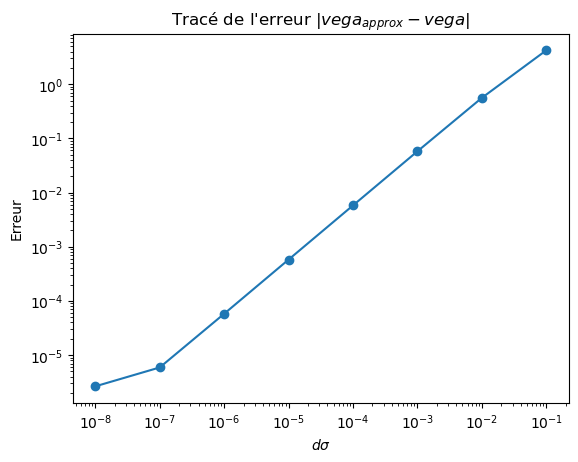

In [47]:
t = 0
S = 110
K = 100
T = 1
sigma = 0.2
r = 0.1
q = 0

errors_values = []
dsigma_values = [10**(-i) for i in range(1,9)]

for dsigma in dsigma_values : 
    val = np.abs(vega_approx(t, S, K, T, sigma, r, q, dsigma) - vega(t, S, K, T, sigma, r, q))
    errors_values.append(val)

plt.plot(dsigma_values, errors_values, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr"$d\sigma$")
plt.ylabel('Erreur')
plt.title(fr"Tracé de l'erreur $|vega_{{approx}} - vega|$")
plt.show()

Nous allons introduire à présent deux mesures de sensibilité supplémentaires utiles pour les **swaps de volatilité**. 

#### 5.4) Le Vanna $\left(\text{Vanna}\right)$. <a id="part54"></a> 

Le vanna est une sensibilité de deuxième ordre qui mesure l'impact combiné d'un changement du prix du sous-jacent 
$S$ et de la volatilité $\sigma$ sur le prix de l'option. Il est défini par : 

$$\boxed {\text{vanna}(V) = \dfrac{\partial^2 V}{\partial S \partial \sigma} = \dfrac{\partial \,\text{vega}(V)}{\partial S} = \dfrac{\partial \Delta}{\partial \sigma}}$$ 

en utilisant le théorème de Schwarz. 

**Calcul dans le cas d'un call / put :**

On rapelle que : 
$$ \text{vega}(C_t) = \text{vega}(P_t) = \dfrac{1}{\sqrt{2\pi}}S\text{e}^{-q(T-t)}\text{e}^{-\frac{d_1^2}{2}}\sqrt{T-t}.$$

$$\Rightarrow \text{vanna}(C_t) = \dfrac{1}{\sqrt{2\pi}}\text{e}^{-q(T-t)}\text{e}^{-\frac{d_1^2}{2}}\sqrt{T-t}-\dfrac{1}{\sqrt{2\pi}}S\text{e}^{-q(T-t)}d_1\text{e}^{-\frac{d_1^2}{2}}\dfrac{\partial d_1}{\partial S}\sqrt{T-t}$$

$$\Leftrightarrow \text{vanna}(C_t) = \dfrac{1}{\sqrt{2\pi}}\text{e}^{-q(T-t)}\text{e}^{-\frac{d_1^2}{2}}\sqrt{T-t}-\dfrac{1}{\sqrt{2\pi}}S\text{e}^{-q(T-t)}d_1\text{e}^{-\frac{d_1^2}{2}}\dfrac{1}{S\sigma\sqrt{T-t}}\sqrt{T-t}$$

$$\Leftrightarrow \text{vanna}(C_t) = -\text{e}^{-q(T-t)}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}\dfrac{d_2}{\sigma},$$

en utilisant le fait que $d_2 = d_1 - \sigma\sqrt{T-t}$. 

On a bien entendu comme $\text{vega}(C_t) = \text{vega}(P_t)$ l'égalité : 

$$\text{vanna}(C_t) = \text{vanna}(P_t).$$

In [48]:
def vanna(t, S, K, T, sigma, r, q) : 
    return -np.exp(-q*(T-t))*1/np.sqrt(2*np.pi)*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)*d_2(t, S, K, T, sigma, r, q)/sigma

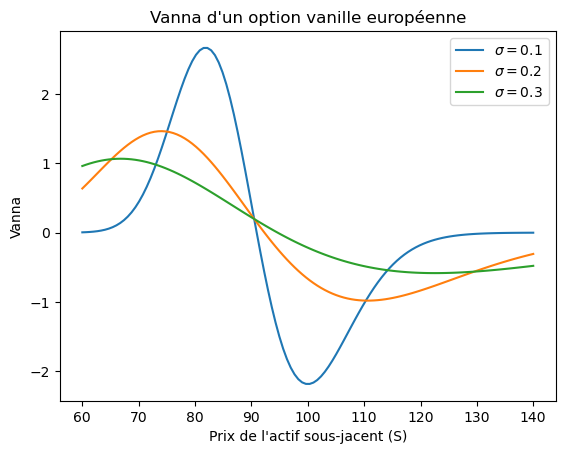

In [49]:
vanna_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    v = [vanna(0, S, K, T, sigma, r, q) for S in S_values]
    vanna_values.append(v)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, vanna_values[i], label=fr"$\sigma = {sigma}$")

plt.title(fr"Vanna d'un option vanille européenne")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Vanna')
plt.legend(); 

#### 5.5) Le Volga $\left(\text{Volga}\right)$. <a id="part55"></a> 

Le volga (pour volatilité gamma), est une mesure de la sensibilité du vega à la volatilité. Formellement, le volga est défini comme la dérivée seconde du prix de l'option par rapport à la volatilité $\sigma$ : 

$$\boxed {\text{volga}(V) = \dfrac{\partial^2 V}{\partial \sigma^2} = \dfrac{\partial \, \text{vega}(V)}{\partial \sigma}}$$

**Calcul dans le cas d'un call / put :**

On rapelle que : 
$$ \text{vega}(C_t) = \text{vega}(P_t) = \dfrac{1}{\sqrt{2\pi}}S\text{e}^{-q(T-t)}\text{e}^{-\frac{d_1^2}{2}}\sqrt{T-t}.$$

Où on note : 

$$d_1 = \dfrac{\ln{\left(\dfrac{S}{K}\right)} + \left(r-q+\dfrac{\sigma ^2}{2}\right)(T-t)}{\sigma \sqrt{T-t}} = \dfrac{\ln\left(\dfrac{S}{K}\right) + (r-q)(T-t)}{\sigma (T-t)} + \dfrac{\sigma \sqrt{T-t}}{2}.$$

$$ \Rightarrow \text{volga}(C_t) = \dfrac{\partial \, \text{vega}(C_t)}{\partial \sigma} = -S\text{e}^{-q(T-t)}\sqrt{T-t}\dfrac{1}{\sqrt{2\pi}}d_1\text{e}^{-\frac{-d_1^2}{2}}\dfrac{\partial d_1}{\partial \sigma}.$$

Avec : 

$$\dfrac{\partial d_1}{\partial \sigma} = -\dfrac{\ln\left(\dfrac{S}{K}\right) + (r-q)(T-t)}{\sigma^2 (T-t)} + \dfrac{\sqrt{T-t}}{2} = -\dfrac{\ln\left(\dfrac{S}{K}\right)+\left(r-q-\frac{\sigma^2}{2}\right)(T-t)}{\sigma^2\sqrt{T-t}} = -\dfrac{d_2}{\sigma}.$$

Finalement : 

$$\text{volga}(C_t) = S\text{e}^{-q(T-t)}\sqrt{T-t}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}}\dfrac{d_1d_2}{\sigma}.$$

Comme $\text{vega}(C_T) = \text{vega}(P_t)$, il vient que $\text{volga}(P_t) = \text{volga}(C_t)$. 

In [50]:
def volga(t, S, K, T, sigma, r, q) : 
    return S*np.exp(-q*(T-t))*np.sqrt(T-t)*1/np.sqrt(2*np.pi)*np.exp(-d_1(t, S, K, T, sigma, r, q)**2/2)*d_1(t, S, K, T, sigma, r, q)*d_2(t, S, K, T, sigma, r, q)/sigma

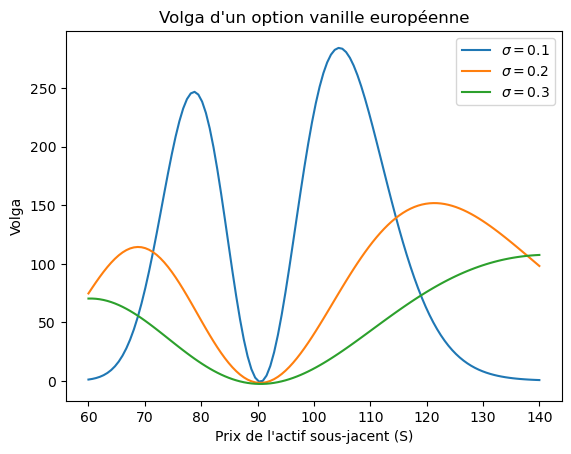

In [51]:
volga_values = []
S_values = np.linspace(60,140,120)

for sigma in sigmas:
    v = [volga(0, S, K, T, sigma, r, q) for S in S_values]
    volga_values.append(v)

for i, sigma in enumerate(sigmas):
    plt.plot(S_values, volga_values[i], label=fr"$\sigma = {sigma}$")

plt.title(fr"Volga d'un option vanille européenne")
plt.xlabel('Prix de l\'actif sous-jacent (S)')
plt.ylabel('Volga')
plt.legend(); 

### 6) EDP de Black-Scholes.<a id="part6"></a>

#### 6.1) Preuve. <a id="part61"></a>

Sous les hypothèses du modèles de Black-Scholes (taux sans risque constant, distribution log-normale du processus du cours l'actif...), le processus suivi par l'actif est un brownien géométrique, caractérisé par l'EDS : 
$$\boxed{
\text{d}S_t = \mu S_t \text{d}t+\sigma S_t \text{d}W_t.}$$ 

Notons $f$ le prix d'un call (ou de tout autre produit dérivé : put, warrant...) lié au titre $S$ ($f$ est fonction de $S$ et de $t$). 
En appliquant la formule d'Itô dépendant du temps à f : 
$$\text{d}f = \dfrac{\partial f}{\partial t}\text{d}t + \dfrac{\partial f}{\partial S}\text{d}S + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\text{d}<S,S>_t$$

$$ \Leftrightarrow \text{d}f = \dfrac{\partial f}{\partial t}\text{d}t + \dfrac{\partial f}{\partial S}\mu S_t \text{d}t+ \dfrac{\partial f}{\partial S}\sigma S_t \text{d}W_t + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2\text{d}t$$ 

$$ \Leftrightarrow \text{d}f = \left(\dfrac{\partial f}{\partial t}+\dfrac{\partial f}{\partial S}\mu S_t + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2  \right)\text{d}t + \dfrac{\partial f}{\partial S}\sigma S_t \text{d}W_t$$ 

À présent, l'objectif est d'introduire une stratégie de couverture pour élimiter la composante aléatoire dans cette équation. 

Considérons un portefeuille $\Pi$ composé de : 
- Une position longue sur l'option, de faleur $f$. 
- Une position courte de $\Delta$ unités de l'actif $S$. 

La valeur du portefeuille est donnée par $\Pi = f - \Delta S_t$. 

Ainsi : 

$$ \text{d} \Pi = \text{d}f - \Delta\text{d}S_t $$ 

$$ \Leftrightarrow \text{d}\Pi = \left(\dfrac{\partial f}{\partial t}+\dfrac{\partial f}{\partial S}\mu S_t + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2  \right)\text{d}t + \dfrac{\partial f}{\partial S}\sigma S_t \text{d}W_t - \Delta\left(\mu S_t\text{d}t + \sigma S_t\text{d}W_t\right)$$ 

$$ \Leftrightarrow \text{d} \Pi = \left(\dfrac{\partial f}{\partial t}+\dfrac{\partial f}{\partial S}\mu S_t -\Delta\mu S_t+ \dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2  \right)\text{d}t + \left(\dfrac{\partial f}{\partial S}\sigma S_t - \Delta\sigma S_t \right)\text{d}W_t $$ 

Le choix de $\Delta$ permettant d'élimier le terme aléatoire $W_t$ est $$\Delta = \dfrac{\partial f}{\partial S},$$
qui est la quantité rencontrée dans la première section de ce document.

On a donc : $$\text{d} \Pi = \left(\dfrac{\partial f}{\partial t}+\dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2  \right)\text{d}t.$$

Cette expression étant déterministre, en vertu de l'absence d'opportunité d'arbitrage, le rendement du portefeuille doit être égal au taux sans risque $r$. 

En effet, de deux choses l'une : 
- si sa rentabilité était supérieure, on emprunte de la liquidité au taux sans risque que l'on investi directement dans $\Pi$. 
- au contraire, si sa rentabilité était moindre, on vend à découvert $\Pi$ et on place les recettes de cette vente au taux sans risque. 

Finalement, $$\text{d}\Pi = r\Pi\text{d}t. $$

Donc : 

$$ r\left(f-\dfrac{\partial f}{\partial S}S_t\right) = \dfrac{\partial f}{\partial t}+\dfrac{1}{2}\dfrac{\partial^2 f}{\partial S^2}\sigma^2S_t^2,$$

$$
\boxed{
\Leftrightarrow \dfrac{\partial f}{\partial t} + \dfrac{1}{2}\sigma^2S_t^2\dfrac{\partial^2 f}{\partial S^2} + rS_t\dfrac{\partial f}{\partial S} - rf = 0
}
$$

qui est l'EDP de Black-Scholes. 

#### 6.2) Interprétation financière et lien avec les grecques. <a id="part62"></a>

Remarqons que l'EDP de Black-Scholes peut se ré-écrire en utilisant les grecques. Cela donne : 

$$ \dfrac{\partial f}{\partial t}+\dfrac{1}{2}\sigma^2S_t^2\Gamma(f)+rS_t\Delta(f) -rf = 0$$ 

$$ \Leftrightarrow \dfrac{\partial f}{\partial t} = r(f - S_t\Delta(f))-\dfrac{\sigma^2S_t^2}{2}\Gamma(f) $$ 

L'approximation par différence finie du membre de gauche donne : 

$$\dfrac{f(S,t + \text{d}t) - f(S,t)}{\text{d}t}= r(f - S_t\Delta(f))-\dfrac{\sigma^2S_t^2}{2}\Gamma(f)$$

$$ \text{d}f = r(f - S_t\Delta(f))\text{d}t - \dfrac{\sigma^2S_t^2}{2}\Gamma(f)\text{d}t $$ 

Une option vanille européenne de prix $f(S,t)$ peut être répliquée (car le marché est complet). Autrement dit il exsite un portefeuille autofinancé $V$ tel que $V(T) = f(S_T, T)$. Le portfeuille $\Pi$ introduit dans la partie précédente convient. Alors : 
- les intérêts $r(f - S_t)\Delta(f))\text{d}t$ sont réalisés sur la position en cash du portefeuille de réplication. 
- la réplication coûte $- \dfrac{\sigma^2S_t^2}{2}\Gamma(f)\text{d}t$ (phénomène de slippage). 

Afin de poursuivre la relation entre d'EDP et les Grecques, une dernière re-formulation donne :
$$ \Theta(f) + \dfrac{1}{2}\sigma^2S_t^2\Gamma(f)+rS_t\Delta(f) -rf = 0$$ 

$$ \Leftrightarrow \Theta(f) + \dfrac{1}{2}\sigma^2S_t^2\Gamma(f) = r(f - S_t\Delta(f))$$ 

Le membre de droite étant négligeable par rapport à celui de gauche une approximation couramment utilisée est : 

$$\boxed{1 + \dfrac{\sigma^2S^2}{2}\dfrac{\Gamma}{\Theta} \approx 0}$$ 

*Quelques précisions concernant cette approximation :* \
*On remarque que si celle ci est vérifier, alors $\Gamma$ et $\Theta$ sont de signes opposés. Pour les calls / puts européens, $\Delta$ est croissante, donc $\Gamma > 0$. Cela signifie $-$ en général $-$ que $\Theta < 0$ : à mesure que l'option se rapproche de l'échéance, sa valeur diminie.* \
*Notons par exemple un cas où nous avons $\Gamma, \Theta >0$ : le cas d'un put $DITM$ (voir $3.$, cas où $S = 80, K = 100$).*

> **Exemple :** Prenons une option d'achat de maturité 6 mois sur un actif ne payant pas de dividendes, où $S = 50$, $\sigma = 0.3$ et $r = 4 \%$. 
>
> Prenons $\dfrac{S}{K} = \{1, 1.1, 1.2, 1.3, 1.5, 0.9, 0.8, 0.7, 0.5\}$. Autrement dit, l'option est $ATM$, $10\%$, $20\%$, $30\%$, et $50\%$ $ITM$, et $10\%$, $20\%$, $30\%$, et $50\%$ $OTM$ respectivement. 

In [52]:
import pandas as pd 

S = 50 
T = 0.5
sigma = 0.3
r = 0.04
q = 0
quotient_values = [0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.5]

data = []
for quotient in quotient_values:
    val = 1 + (sigma**2 * S**2 / 2) * gamma(0, S, S/quotient, T, sigma, r, q) / theta_call(0, S, S/quotient, T, sigma, r, q)
    data.append([quotient, val])

df = pd.DataFrame(data, columns=['S/K', "Valeur"])

print(df) 

   S/K    Valeur
0  0.5  0.050520
1  0.7  0.082234
2  0.8  0.106837
3  0.9  0.141157
4  1.0  0.189707
5  1.1  0.258178
6  1.2  0.351801
7  1.3  0.471053
8  1.5  0.736077


**Remarque :** L'approximation $1 + \dfrac{\sigma^2S^2}{2}\dfrac{\Gamma}{\Theta} \approx 0$ est plus pertinente lorsque les options sont deep out-of-the-money $\left(\dfrac{S}{K} << 1\right)$, en comparaison avec les options deep in-the-money $\left(\dfrac{S}{K} >> 1\right)$. 

###  Appendice : Preuve de la formule ($\star$). <a id="partappendice"></a> 


Montrons que :

$$S\text{e}^{-q(T-t)}\mathcal{N}'(d_1) = K\text{e}^{-r(T-t)}\mathcal{N}'(d_2)  \,\, (\star)$$

La fonction $x \rightarrow \dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{x^2}{2}}$ et continue, et l'intégrale impropre $\displaystyle \int_{-\infty}^z \dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{x^2}{2}} \,dx$ existe $\forall z \in \mathbb{R}$, par positivité de l'intégrant.  En dérivant on obtient : 

$$\left[\displaystyle \int_{-\infty}^z \dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{x^2}{2}} \,dx \right ]' = \dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{z^2}{2}} := \mathcal{N}'(z).$$

Donc $(\star)$ se réécrit : 

$$S\text{e}^{-q(T-t)}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_1^2}{2}} = K\text{e}^{-r(T-t)}\dfrac{1}{\sqrt{2\pi}}\text{e}^{-\frac{d_2^2}{2}}$$ 

$$\Leftrightarrow S\dfrac{\text{e}^{(r-q)(T-t)}}{K} = \exp\left(\dfrac{d_1^2-d_2^2}{2}\right)$$

En remarquant que $d_1^2-d_2^2 = d_1^2-\left(d_1 - \sigma\sqrt{T-t}\right)^2 = 2d_1\sigma\sqrt{T-t}-\sigma^2(T-t) = 2\left (\ln\left(\dfrac{S}{K}\right)+(r-q)(T-t)\right) = 2\ln\left(\dfrac{S\text{e}^{(r-q)(T-t)}}{K}\right),$ il suffira alors de remplacer le terme $d_1^2-d_2^2$ dans l'égalité précédente.  